In [ ]:
## These two packages were not included in the requirement sheet.
## If you don't have them installed, please run this cell or directly in your command line

!pip install matplotlib
!pip install ipywidgets

In [1]:
## Import Jupyter Notebook specifics
%matplotlib notebook
from ipywidgets import *

## Import numpy
import numpy as np

## Import SimpleITK - We can access the SimpleElastix from here
import SimpleITK as sitk

## Import supporting files
import support_files.dataManagement as dataManage
import support_files.imageUtilities as imageUtilities
import support_files.t1MappingPredict as t1Map
from support_files.imageBrowse import imageBrowse

# Introduction to T1 mapping

## Why do we need mapping?
The image formation in a MRI experiment is a complex process. Underlying parameters of differently tissues respond differently to the external magnetic field produced by the machine. This creates changes in image contrast, allowing for tissue differentiation.

However, as most of physical phenomena, this is a noisy procedure, since internal (i.e. variation in tissue susceptibility) and external factors (i.e. inhomogeneity of magnetic fields, imperfect RF pulses) affect the appearance of the final weighted images. This happens because the observed signal amplitudes are not only dependent on the tissue properties, therefore making longitudinal analysis much harder.

## Quantitative mapping
Quantitative mapping aims to reduce the corrupting factors by estimating the invariant tissue property directly from the observed signal. T1 mapping, the focus of this exercise, can be performed in several ways, but the most common approaches are based on statistical iterative algorithms, such as Bayesian inference or the Maximum Likelihood Estimator (MLE).

The optimisation algorithm fits a given signal model to the acquired weighted images to try to recover the tissue properties that best explain the observed signal. In the cases presented here, Inversion Recovery (IR) based sequences were used and the approximated signal model is given by:

$$f_{n}\left(A, B, T_{1}\right)=\left|A-B e^{-\frac{TI_{n}}{T_{1}}}\right|$$

where A is proportional to the proton density of the sample, B is related to the inversion efficiency of the RF pulses, TI<sub>n</sub> is the inversion time for the n<sup>th</sup> image in the series and T<sub>1</sub> is the longitudinal relaxation time in a voxel. 

By varying the time the RF pulse is applied (the TI), the contrast of the images change according to their A, B and T<sub>1</sub> values and the signal model can be used to fit the time series at a voxel. In the figure below you can see how the signal is dependent on the acquisition TI. 


You can observe how the signal from different tissues evolve:

<img src="files/support_images/Synt_T1w.png">

The image above only shows 5 images out of 23 images in total. The plot below shows the signal evolution for gray matter (GM), white matter (WM) and csf. Each point in the curve corresponds to the voxel intensity at a give inversion time.

<img src="files/support_images/T1w_signalEvolution.png">

The estimation algorithm, through iterative optimisation methods, trys to predict which values for T<sub>1</sub>, A and B that could have originated this signal evolution, based on the signal model. In the plot above, by observing the inflexion points, it is possible to infer that T<sub>1,CSF </sub> > T<sub>1,GM </sub> > T<sub>1,WM </sub>.



## Visualising the weighted images
Now you can load and visualise our first example, a set of synthetic weighted images simulated using the signal model above. Explore the variation in signal intensity and check for different signal evolution curves for multiple voxels:

In [2]:
## Loading synthetic data
filePath = "./support_data/synthetic_t1w.h5"
originalSeries, groundTruthMaps, mask = dataManage.loadSyntheticData(filePath, sliceSelect=38)
gt_t1Map = groundTruthMaps

Loading data
Data loaded


<IPython.core.display.Javascript object>


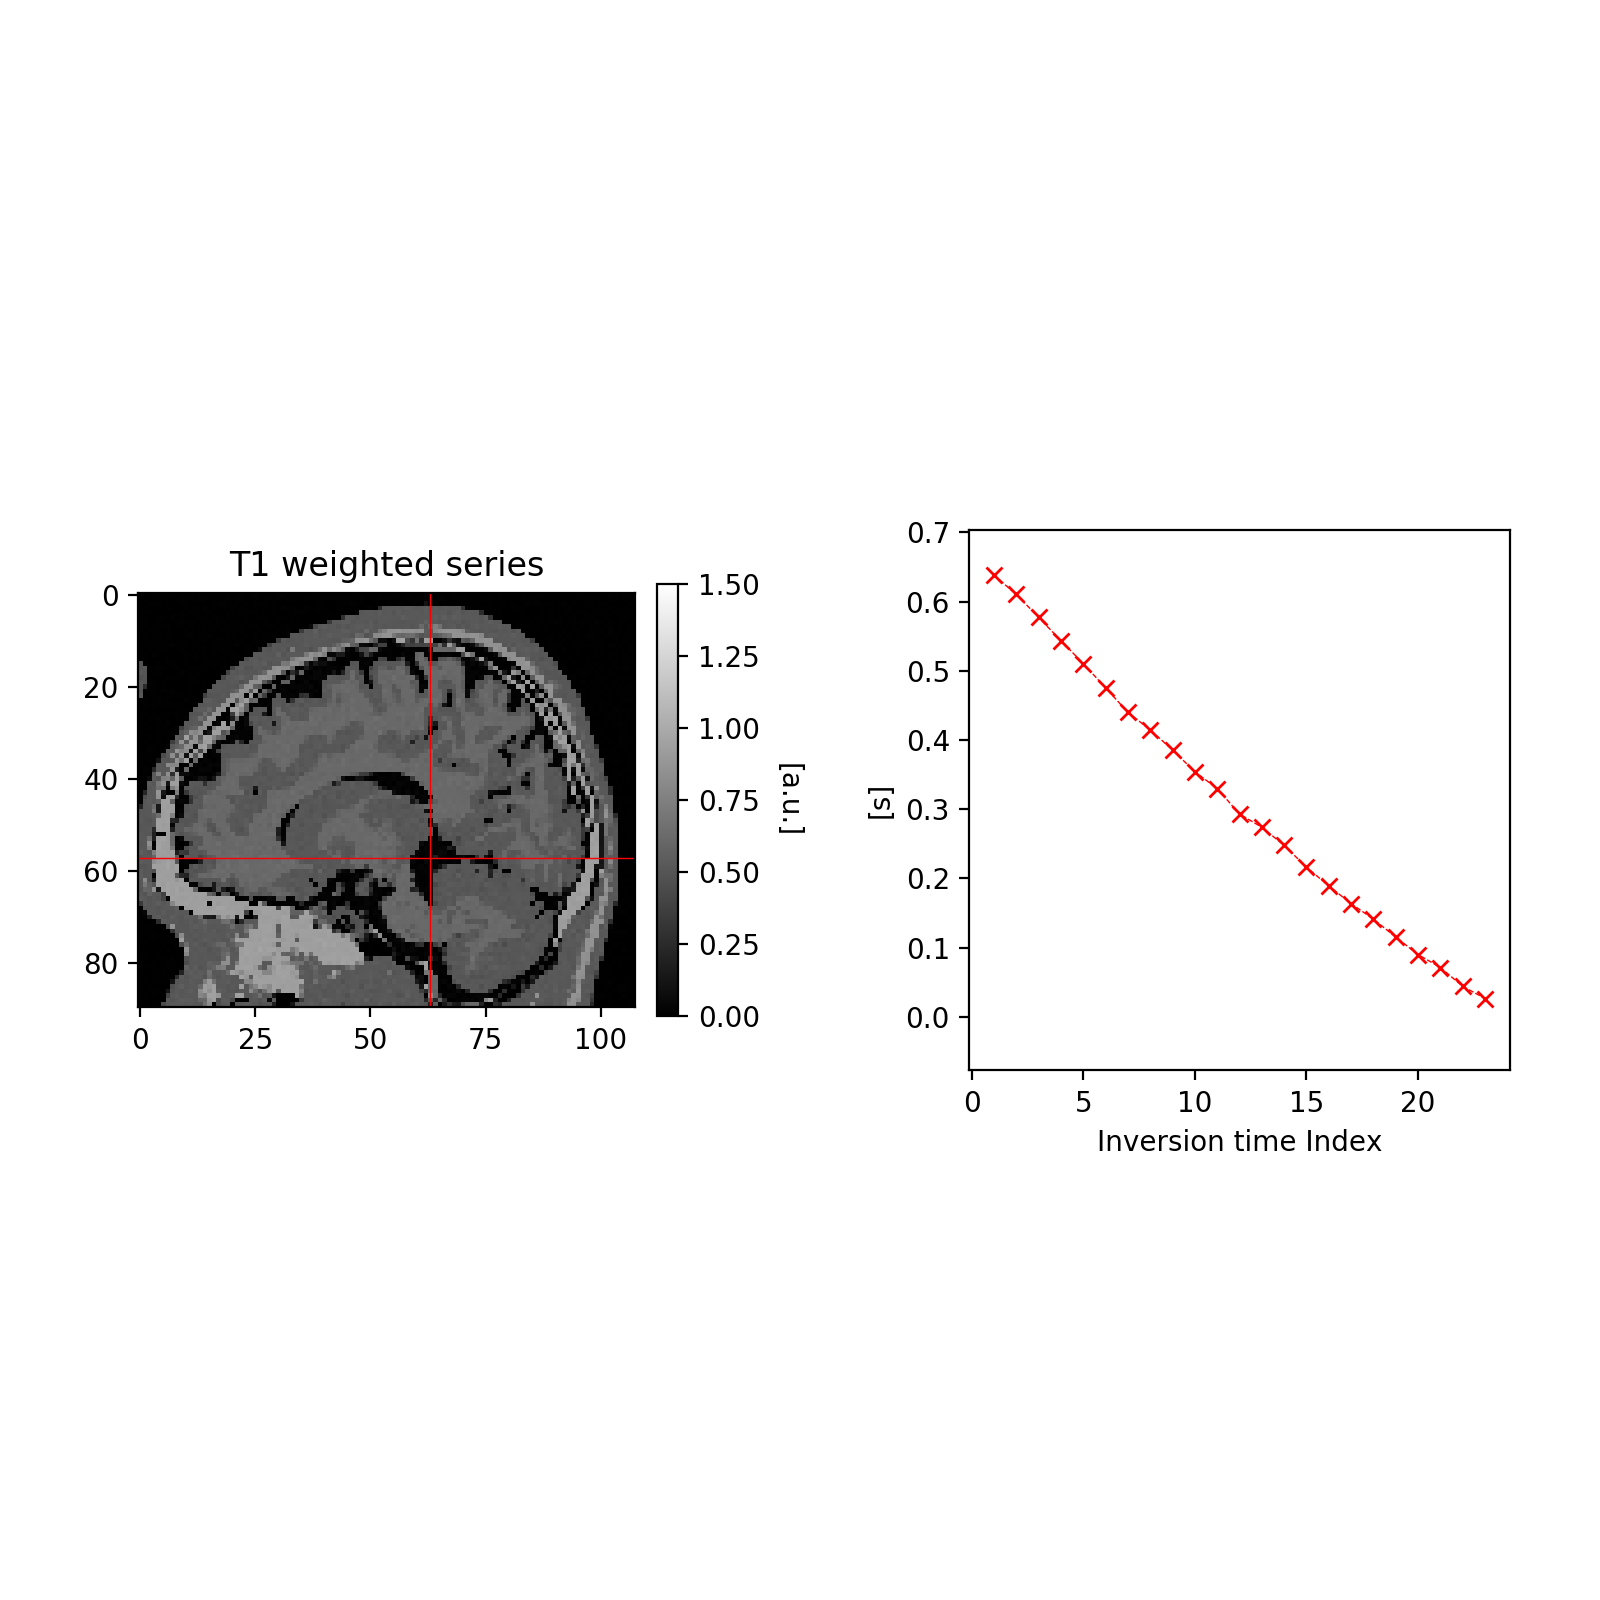

interactive(children=(IntSlider(value=11, description='inversion_time', max=22), Output()), _dom_classes=('wid…

In [5]:
## Visualisation
imageBrowse(originalSeries["weighted_series"], 
            im_ax = 0, 
            rang_min = 0.0,
            rang_max = 1.5,
            colormap_c = 'gray',
            fig_title='T1 weighted series',
            ylabel='[a.u.]'
           )

## How does motion affect the images

### Patient motion

In an Inversion Recovery experiment, to permit the complete relaxation of the signal, the images at each inversion times are acquired spaced from one another. Due to inherent patient movement during the scan, the images at different TI<sub>s</sub> won't be aligned. This means that throughout the time series, a given voxel in the images won't, necessarily, correspond to the same spatial location, since they are misaligned.

In the example below, we introduced simulated motion to the synthetic dataset from before. In the same way as above, you can visualise the different images, and check how the simulated motion affects the signal evolution.

In [6]:
## Loading motion corrupted data
filePath = "./support_data/synthetic_t1w_deformed.nii"
corruptedSeries = {}
corruptedSeries["weighted_series"] = dataManage.readNii(filePath)
corruptedSeries["echo_times"] = originalSeries["echo_times"]

<IPython.core.display.Javascript object>


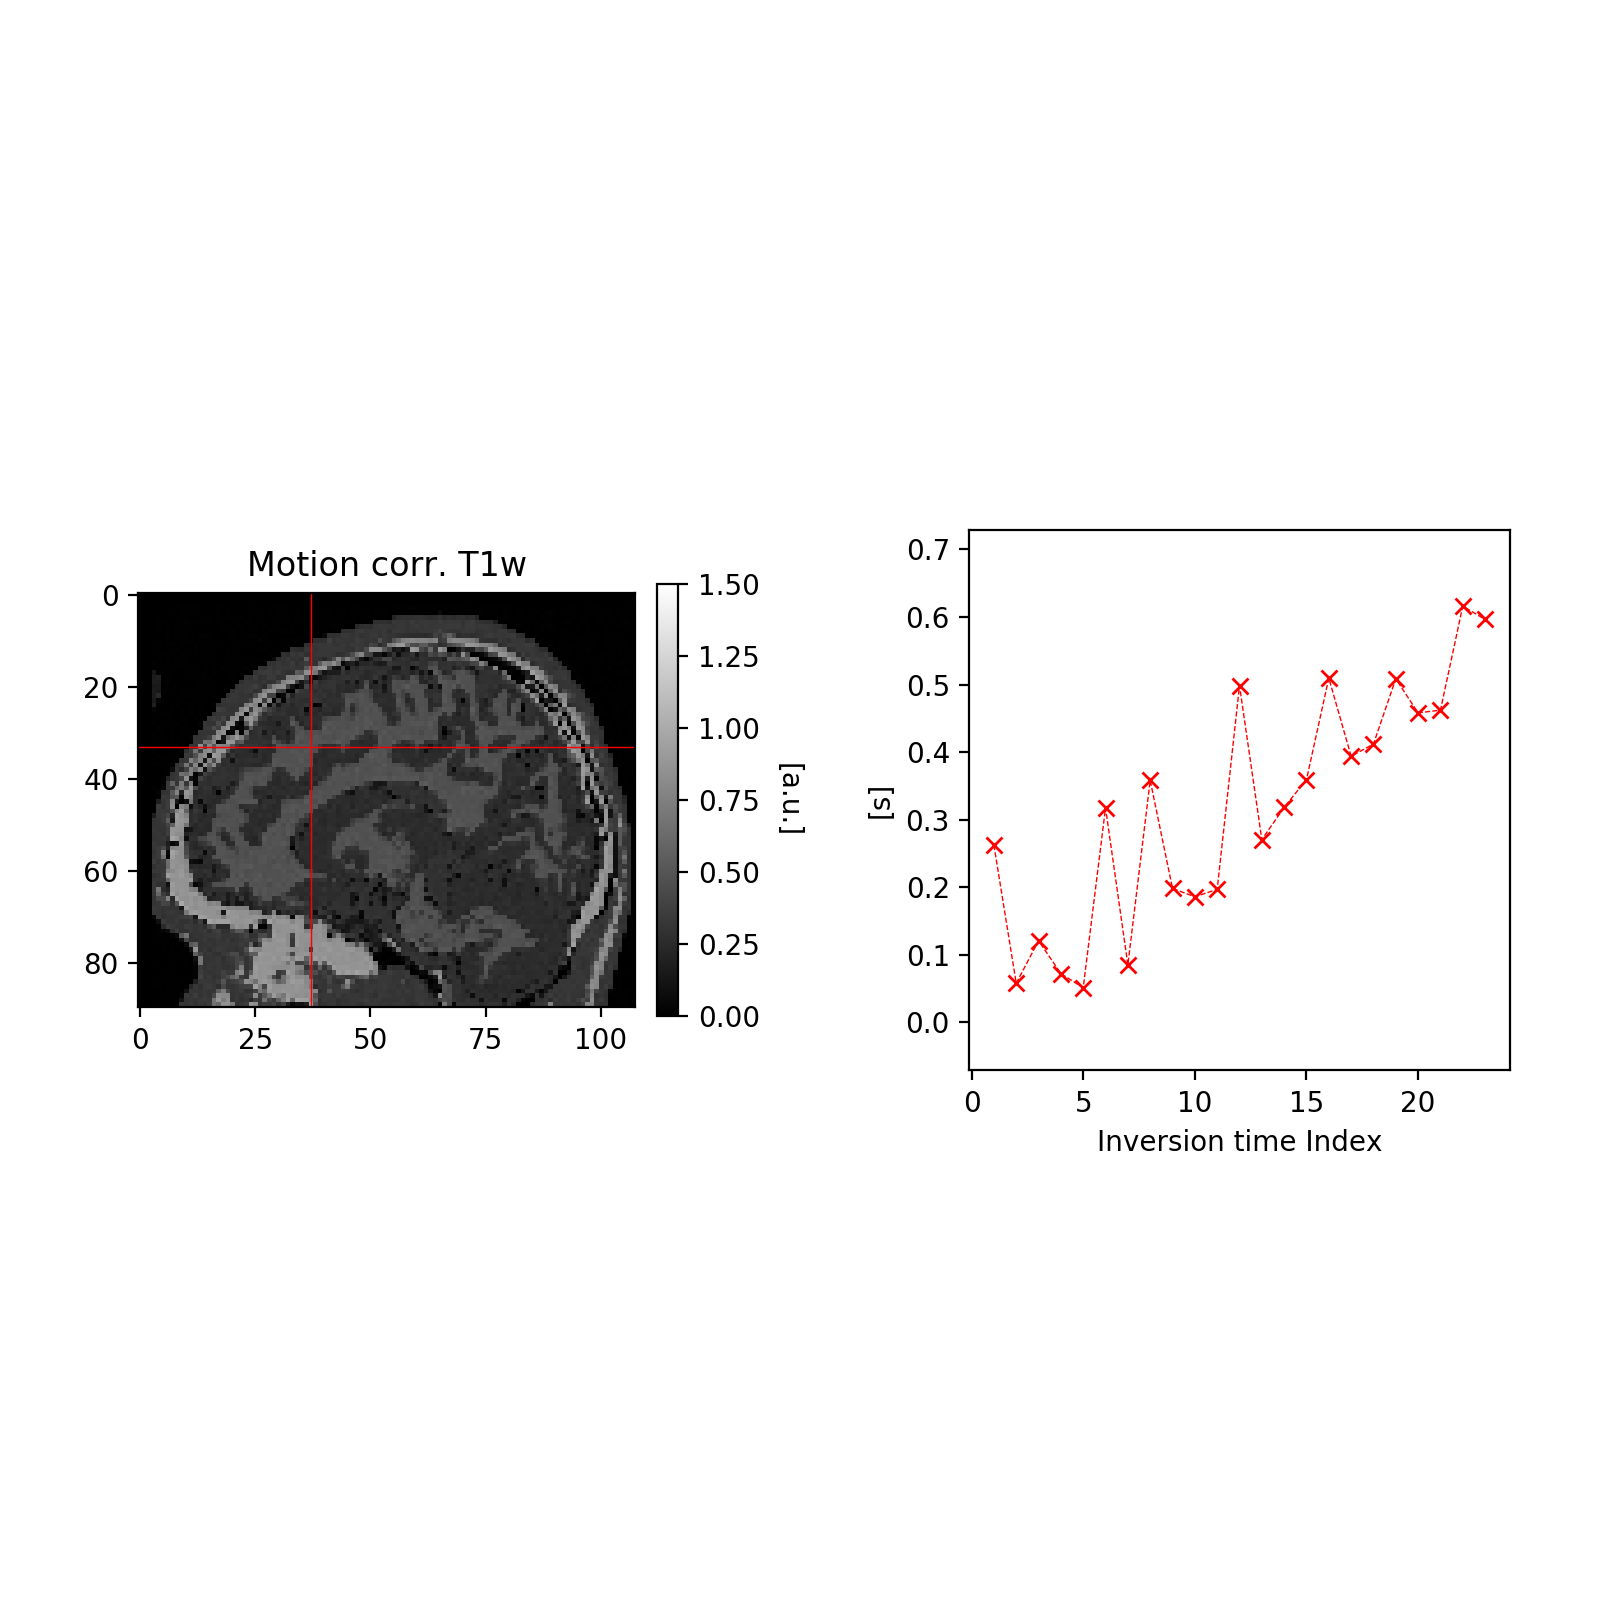

interactive(children=(IntSlider(value=11, description='inversion_time', max=22), Output()), _dom_classes=('wid…

In [7]:
## Visualisation
imageBrowse(corruptedSeries["weighted_series"], 
            im_ax = 0, 
            rang_min = 0.0, 
            rang_max = 1.5, 
            colormap_c='gray', 
            fig_title='Motion corr. T1w',
            ylabel='[a.u.]'
           )

### Impact of motion on T1 mapping
To demonstrate how this affects the mapping results, you can run the cell below. It evoques a MLE-based optimisation method which estimates the A, B and T<sub>1</sub> maps, however, here, we are only interested in the latter. 

In [5]:
# Define the T1Mapping wrapper
def t1Mapping(data):
    print('-'*40)
    print('T1 estimation started')
    
    configurationFilePath = './support_files/configuration_file_mle.txt'
    predictedMaps, simulatedWeightedSequence = t1Map.predictMapping(data, configurationFilePath, True)
    
    print('T1 estimation finished')
    return np.array(predictedMaps), np.array(simulatedWeightedSequence)

In [7]:
## Run T1 mapping for original data
qMaps, estimatedWeightedSeriesOriginal = t1Mapping(originalSeries)
original_t1Map = qMaps[-1].detach().numpy()

## Run T1 mapping for motion corrupted data
qMaps, estimatedWeightedSeriesCorrupted = t1Mapping(corruptedSeries)
corrupted_t1Map = qMaps[-1].detach().numpy()


----------------------------------------
T1 estimation started
Using CPU
Iteration: 0, Loss: 30318.72265625
Iteration: 1, Loss: 29193.12109375
Iteration: 2, Loss: 28131.607421875
Iteration: 3, Loss: 27037.107421875
Iteration: 4, Loss: 26008.72265625
Iteration: 5, Loss: 24943.806640625
Iteration: 6, Loss: 23962.388671875
Iteration: 7, Loss: 22924.873046875
Iteration: 8, Loss: 21970.474609375
Iteration: 9, Loss: 20991.2421875
Iteration: 10, Loss: 20071.58203125
Iteration: 11, Loss: 19162.84765625
Iteration: 12, Loss: 18273.51953125
Iteration: 13, Loss: 17423.314453125
Iteration: 14, Loss: 16545.17578125
Iteration: 15, Loss: 15724.7568359375
Iteration: 16, Loss: 14887.794921875
Iteration: 17, Loss: 14093.671875
Iteration: 18, Loss: 13329.8203125
Iteration: 19, Loss: 12572.400390625
Iteration: 20, Loss: 11877.0009765625
Iteration: 21, Loss: 11199.330078125
Iteration: 22, Loss: 10577.3505859375
Iteration: 23, Loss: 10015.138671875
Iteration: 24, Loss: 9492.412109375
Iteration: 25, Loss: 904

Iteration: 212, Loss: 892.4653930664062
Iteration: 213, Loss: 886.2883911132812
Iteration: 214, Loss: 880.4968872070312
Iteration: 215, Loss: 875.47216796875
Iteration: 216, Loss: 871.4625244140625
Iteration: 217, Loss: 868.112548828125
Iteration: 218, Loss: 865.4512939453125
Iteration: 219, Loss: 863.6195068359375
Iteration: 220, Loss: 861.2996826171875
Iteration: 221, Loss: 858.6622314453125
Iteration: 222, Loss: 856.0132446289062
Iteration: 223, Loss: 853.162353515625
Iteration: 224, Loss: 850.33935546875
Iteration: 225, Loss: 847.8941040039062
Iteration: 226, Loss: 845.7020874023438
Iteration: 227, Loss: 843.5626831054688
Iteration: 228, Loss: 841.4917602539062
Iteration: 229, Loss: 839.359619140625
Iteration: 230, Loss: 837.0900268554688
Iteration: 231, Loss: 834.9029541015625
Iteration: 232, Loss: 832.8385620117188
Iteration: 233, Loss: 830.8898315429688
Iteration: 234, Loss: 828.9793090820312
Iteration: 235, Loss: 827.1187133789062
Iteration: 236, Loss: 825.2277221679688
Iterati

Iteration: 424, Loss: 675.4137573242188
Iteration: 425, Loss: 674.9593505859375
Iteration: 426, Loss: 674.4829711914062
Iteration: 427, Loss: 674.0035400390625
Iteration: 428, Loss: 673.539794921875
Iteration: 429, Loss: 673.0839233398438
Iteration: 430, Loss: 672.6163330078125
Iteration: 431, Loss: 672.1387329101562
Iteration: 432, Loss: 671.6834106445312
Iteration: 433, Loss: 671.2120971679688
Iteration: 434, Loss: 670.7542724609375
Iteration: 435, Loss: 670.3013305664062
Iteration: 436, Loss: 669.8468017578125
Iteration: 437, Loss: 669.393310546875
Iteration: 438, Loss: 668.9313354492188
Iteration: 439, Loss: 668.48095703125
Iteration: 440, Loss: 668.0359497070312
Iteration: 441, Loss: 667.5908813476562
Iteration: 442, Loss: 667.1669921875
Iteration: 443, Loss: 666.7197265625
Iteration: 444, Loss: 666.2973022460938
Iteration: 445, Loss: 665.8699340820312
Iteration: 446, Loss: 665.4418334960938
Iteration: 447, Loss: 665.0236206054688
Iteration: 448, Loss: 664.5912475585938
Iteration:

Iteration: 142, Loss: 6300.77099609375
Iteration: 143, Loss: 6289.7275390625
Iteration: 144, Loss: 6278.837890625
Iteration: 145, Loss: 6268.15771484375
Iteration: 146, Loss: 6257.71533203125
Iteration: 147, Loss: 6247.54296875
Iteration: 148, Loss: 6237.44970703125
Iteration: 149, Loss: 6227.51171875
Iteration: 150, Loss: 6217.787109375
Iteration: 151, Loss: 6208.23046875
Iteration: 152, Loss: 6198.8359375
Iteration: 153, Loss: 6189.61376953125
Iteration: 154, Loss: 6180.53759765625
Iteration: 155, Loss: 6171.6240234375
Iteration: 156, Loss: 6162.82177734375
Iteration: 157, Loss: 6154.2197265625
Iteration: 158, Loss: 6145.75
Iteration: 159, Loss: 6137.30126953125
Iteration: 160, Loss: 6129.0029296875
Iteration: 161, Loss: 6120.95263671875
Iteration: 162, Loss: 6113.07470703125
Iteration: 163, Loss: 6105.37548828125
Iteration: 164, Loss: 6097.83349609375
Iteration: 165, Loss: 6090.4970703125
Iteration: 166, Loss: 6083.341796875
Iteration: 167, Loss: 6076.34619140625
Iteration: 168, Los

Iteration: 364, Loss: 5735.3603515625
Iteration: 365, Loss: 5735.03466796875
Iteration: 366, Loss: 5734.72314453125
Iteration: 367, Loss: 5734.384765625
Iteration: 368, Loss: 5734.0546875
Iteration: 369, Loss: 5733.72802734375
Iteration: 370, Loss: 5733.43017578125
Iteration: 371, Loss: 5733.10791015625
Iteration: 372, Loss: 5732.78662109375
Iteration: 373, Loss: 5732.474609375
Iteration: 374, Loss: 5732.14501953125
Iteration: 375, Loss: 5731.83154296875
Iteration: 376, Loss: 5731.5634765625
Iteration: 377, Loss: 5731.2666015625
Iteration: 378, Loss: 5730.953125
Iteration: 379, Loss: 5730.65087890625
Iteration: 380, Loss: 5730.3876953125
Iteration: 381, Loss: 5730.06787109375
Iteration: 382, Loss: 5729.76416015625
Iteration: 383, Loss: 5729.49658203125
Iteration: 384, Loss: 5729.21533203125
Iteration: 385, Loss: 5728.9111328125
Iteration: 386, Loss: 5728.654296875
Iteration: 387, Loss: 5728.38232421875
Iteration: 388, Loss: 5728.10205078125
Iteration: 389, Loss: 5727.8212890625
Iterati

### Comparing to the known ground-truth (only in simulated experiments)
An advantage of using simulated data is that the ground-truth maps (A, B and T<sub>1</sub>) are known. To evaluate the precision of the estimation, we can directly compared the estimated maps to the known ground-truth:

In [ ]:
## Comparison plot
imageUtilities.compare_predictions(gt_t1Map*mask,
                                   original_t1Map*mask, 
                                   colormap_c='hot', 
                                   text_a='GT T1 map', 
                                   text_b='Estimated T1 map'
                                  )

imageUtilities.compare_predictions(gt_t1Map*mask, 
                                   corrupted_t1Map*mask,
                                   colormap_c='hot', 
                                   text_a='GT T1 map', 
                                   text_b='Estimated T1 map'
                                  )

imageUtilities.compare_predictions(original_t1Map*mask,
                                   corrupted_t1Map*mask, 
                                   colormap_c='hot', 
                                   text_a='GT T1 map',
                                   text_b='Estimated T1 map'
                                  )


### Checking the residuals
An effective way to verify if the mapping was performed correctly is to check the residuals of the fitted data. We can use the signal model to generate simulated weighted images, which can be compared to the original observed data. This shows us if the estimated parameters are, indeed, possible solutions to explain the observed data. The optimal residual would yield only noise (i.e. no brain structure should be visible).

<IPython.core.display.Javascript object>


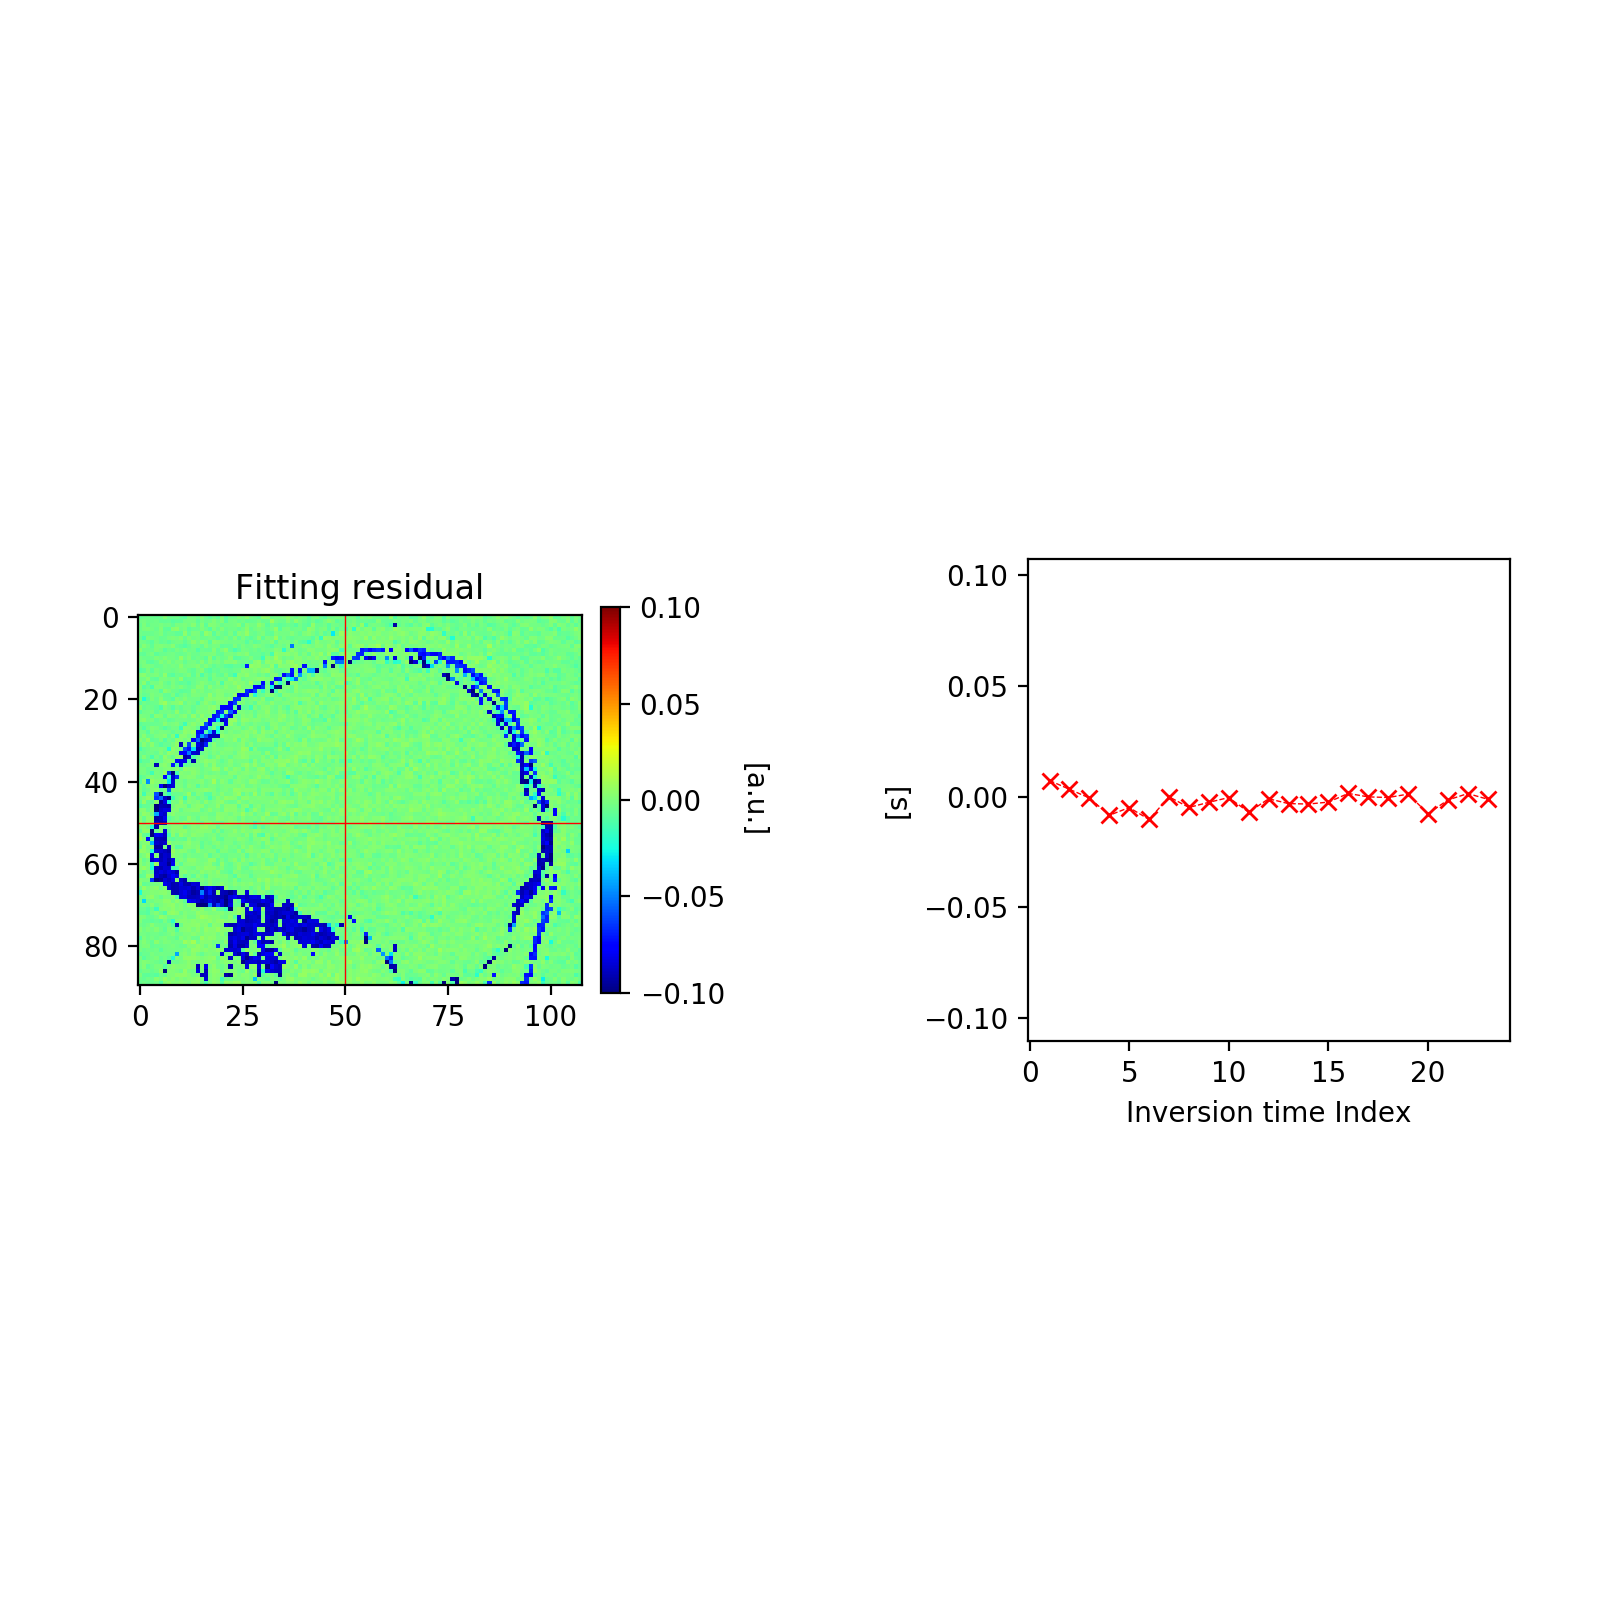

interactive(children=(IntSlider(value=11, description='inversion_time', max=22), Output()), _dom_classes=('wid…

In [8]:
## Calculate and plot the residuals for the non-corrupted estimates
residualOriginal = estimatedWeightedSeriesOriginal - originalSeries["weighted_series"]
imageBrowse(residualOriginal, 
            im_ax = 0, 
            rang_min = -0.1, 
            rang_max = 0.1,
            colormap_c='jet', 
            fig_title='Fitting residual',
            ylabel='[a.u.]'
           )

<IPython.core.display.Javascript object>


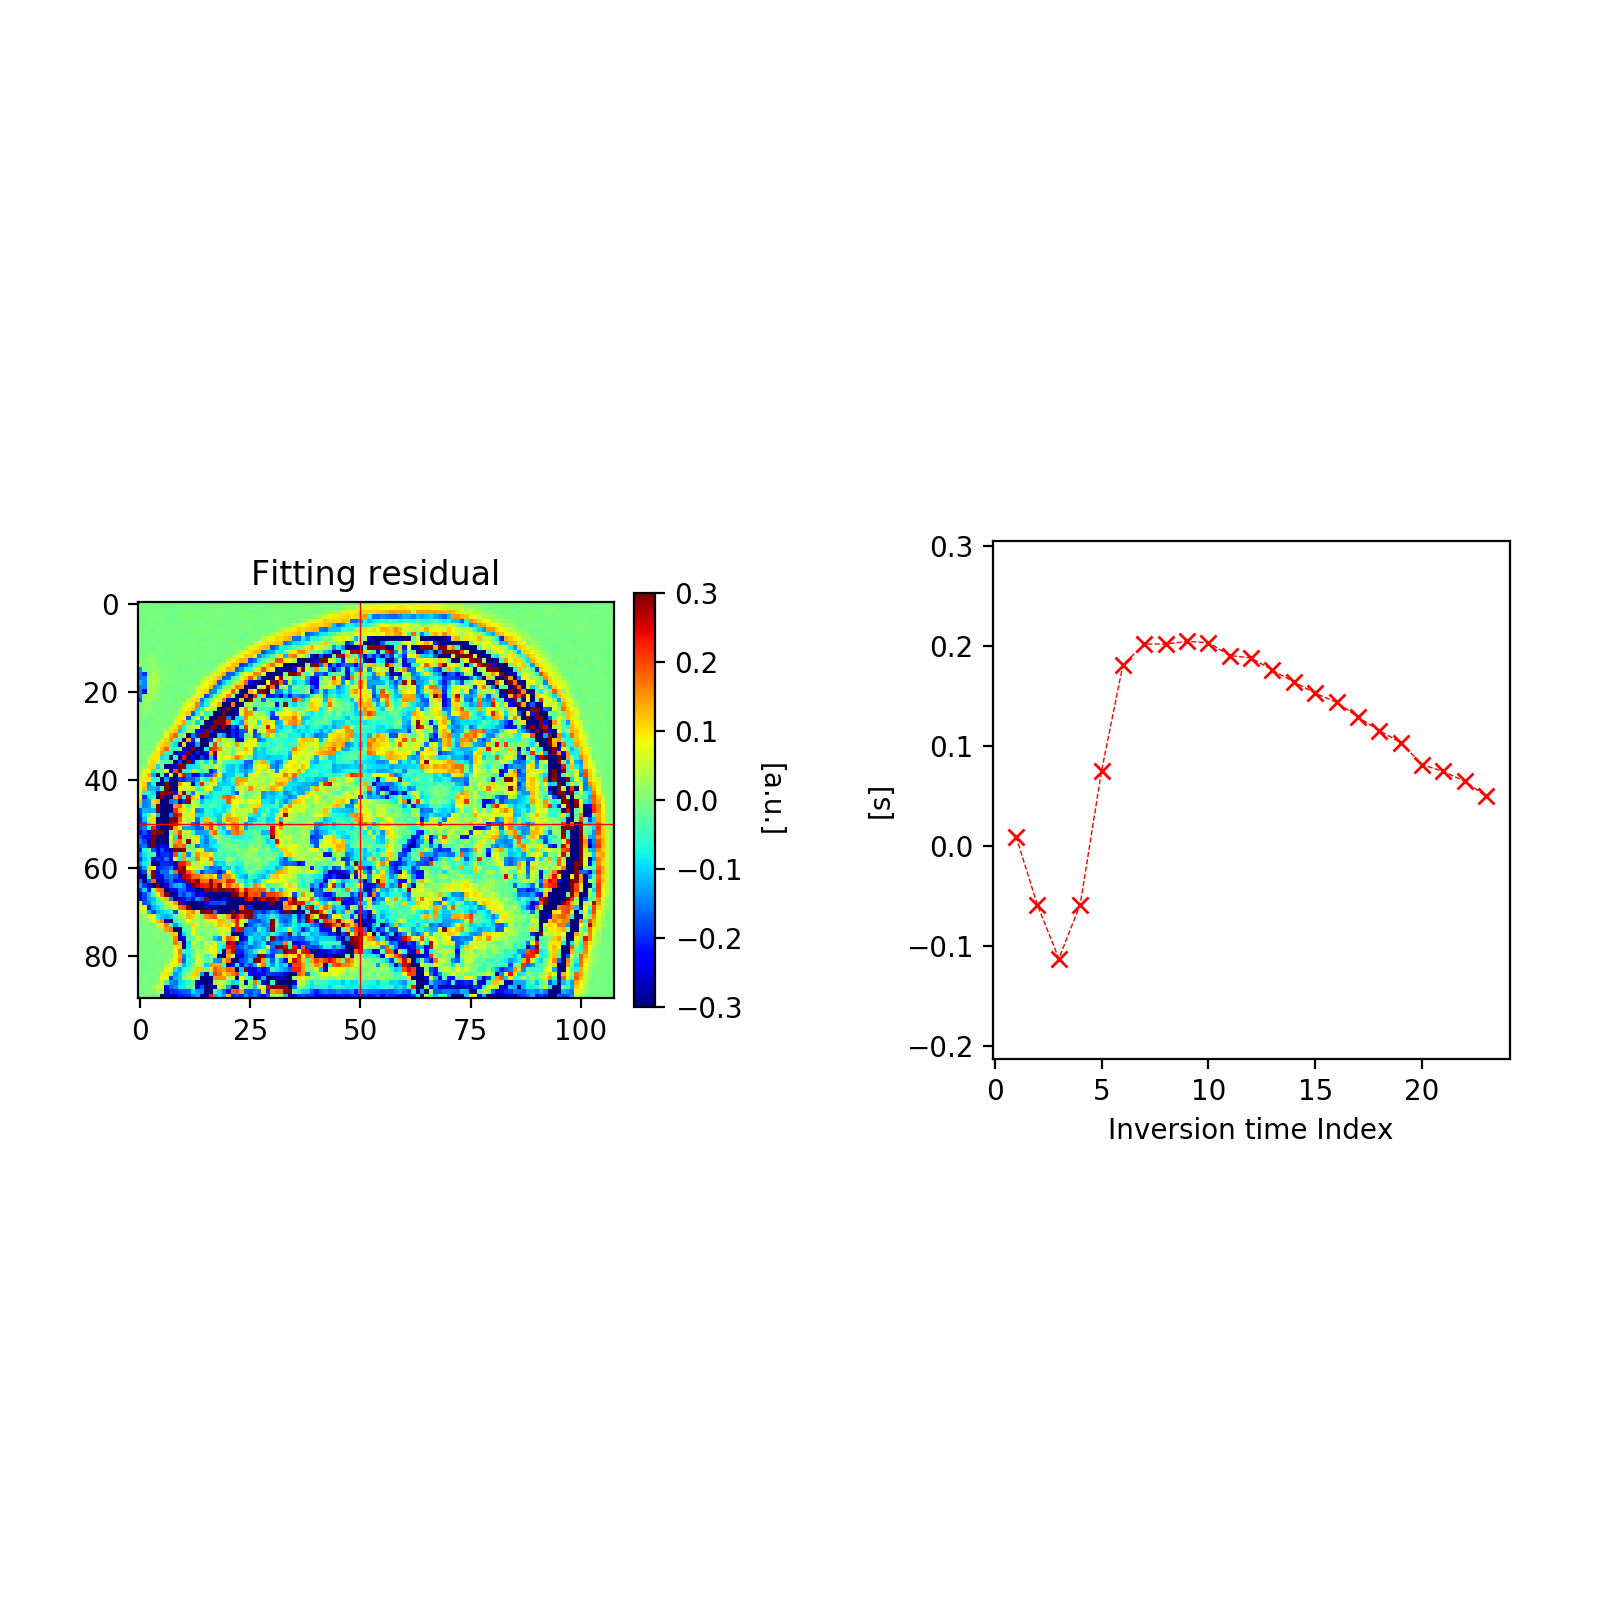

interactive(children=(IntSlider(value=11, description='inversion_time', max=22), Output()), _dom_classes=('wid…

In [9]:
## Calculate and plot the residuals for the motion corrupted estimates
residualCorrupted = estimatedWeightedSeriesCorrupted - originalSeries["weighted_series"]
imageBrowse(residualCorrupted, 
            im_ax = 0, 
            rang_min = -0.3, 
            rang_max = 0.3, 
            colormap_c='jet',
            fig_title='Fitting residual',
            ylabel='[a.u.]'
           )

## Motion compensation - Image registration
As we observed previously, patient motion during the scans can have a negative effect in the estimated maps. Image registration, as performed by Elastix and SimpleElastix, can help with this by aligning the images to each other, reducing the spatial displacement of voxels.

Now, we will use SimpleElastix to perform registration of the corrupted images from the example above. We use SimpleElastix because its integration with Python (and many other languages) is easy. Additionally, the object-oriented structure in which the tool was written gives an intuitive way to use it.

#### Parameter File
As explained previously, Elastix uses a set of instructions to execute. There are several ways to tell Elastix how to perform the registration. Here, for simplicity, we will use a parameter file available in the extensive community-built database. For your convenience, the file is already located in the working directory.

However, if your application demands a different type of data structure, you can go to http://elastix.bigr.nl/wiki/index.php/Parameter_file_database and check what the community made available to us!

In [6]:
# Define the elastix wrapper
def elastixRegister(fixedImage, movingImage, parameterMapPath):
    print("Applying registration")
    
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)
    
    parameterMap = sitk.ReadParameterFile(parameterFilePath)
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()
    
    resultImage = elastixImageFilter.GetResultImage()
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    
    procData = sitk.GetArrayFromImage(resultImage)
    procData = np.transpose(procData, (0,3,2,1))
    
    print("Registration finished")
    
    return procData, transformParameterMap

In [ ]:
## Perform registration
filePath = "./support_data/synthetic_t1w_deformed.nii"
parameterFilePath = "./ParametersFile/par_groupwise/par_real_data/par_groupwise_DTI-BRAIN.txt"

sitk_fixed, sitk_moving = dataManage.prepareDataForElastix(filePath)
processedData, transformParameterMap = elastixRegister(sitk_fixed, sitk_moving, parameterFilePath)

registeredSeries = {}
registeredSeries['weighted_series'] = processedData
registeredSeries['echo_times'] = originalSeries['echo_times']

Applying registration


#### Visualising registered data
You can now visualise the registered data and compare it to the corrupted and original images. Notice how the signal evolution curve changes for the same voxel in each case. Additionally, although much better than the corrupted images, you still might see a slight misalignment between the registered images. Registration is a hard problem and, without fine tunning of the parameters, results are often suboptimal.

In [ ]:
imageBrowse(originalSeries["weighted_series"], 
            im_ax = 0, 
            rang_min = 0.0, 
            rang_max = 1.5,
            colormap_c='gray', 
            fig_title='Original T1w',
            ylabel='[a.u.]'
           )

imageBrowse(corruptedSeries["weighted_series"], 
            im_ax = 0, 
            rang_min = 0.0, 
            rang_max = 1.5, 
            colormap_c='gray', 
            fig_title='Motion curr. T1w',
            ylabel='[a.u.]'
           )

imageBrowse(registeredSeries["weighted_series"], 
            im_ax = 0, 
            rang_min = 0.0,
            rang_max = 1.5, 
            colormap_c='gray', 
            fig_title='Registered T1w series',
            ylabel='[a.u.]'
           )

#### T1 mapping of registered images
After registration, we can now perform the T<sub>1</sub> mapping of the corrected data. We expect improved results compared to the motion corrupted example. However, due to the residual misalignments observed, the T<sub>1</sub> map from the original data has higher accuracy. We can check that by evaluating the residuals of the prediction, as done before.

In [ ]:
# T1 mapping with registered images
qMaps, estimatedWeightedSeriesRegistered = t1Mapping(registeredSeries)
registered_t1Map = qMaps[-1].detach().numpy()

In [ ]:
## Calculate and plot the residuals for the registered estimates
residualRegistered = estimatedWeightedSeriesRegistered - originalSeries["weighted_series"]
imageBrowse(residualRegistered, 
            im_ax = 0, 
            rang_min = 0.0, 
            rang_max = 0.1, 
            colormap_c='hot', 
            fig_title='Motion-free residual',
            ylabel='[a.u.]'
           )


# ---------------------------------------------------------------------------------------
# Now it's your turn!

In the folder './support_data/' you will find an example of in-vivo data, acquired using an Inversion Recovery sequence. The data structure is similar to what was explained above. Using similar steps as before, you should:

1. Load and visualise your data
2. Do the T1 mapping with the original data and check the quality of fit (Check the residual)
3. Perform the image registration (you can use the same parameter file)
4. Again, perform the T1 mapping with the registered data
5. Verify results and compare the estimates of step 4 with the original estimates (step 2).

#### Loading In Vivo data
Implemented for you :)

In [4]:
## This part is given, since the loading method is different.
## Load In-vivo data
filePath = "./support_data/inVivo.mat"
inVivoSeries = dataManage.loadRealData(filePath, 10)

Loading data
(13, 256, 256, 40)
Data loaded
()
saving data
save finished


#### Visualise the data
Implement me...

<IPython.core.display.Javascript object>


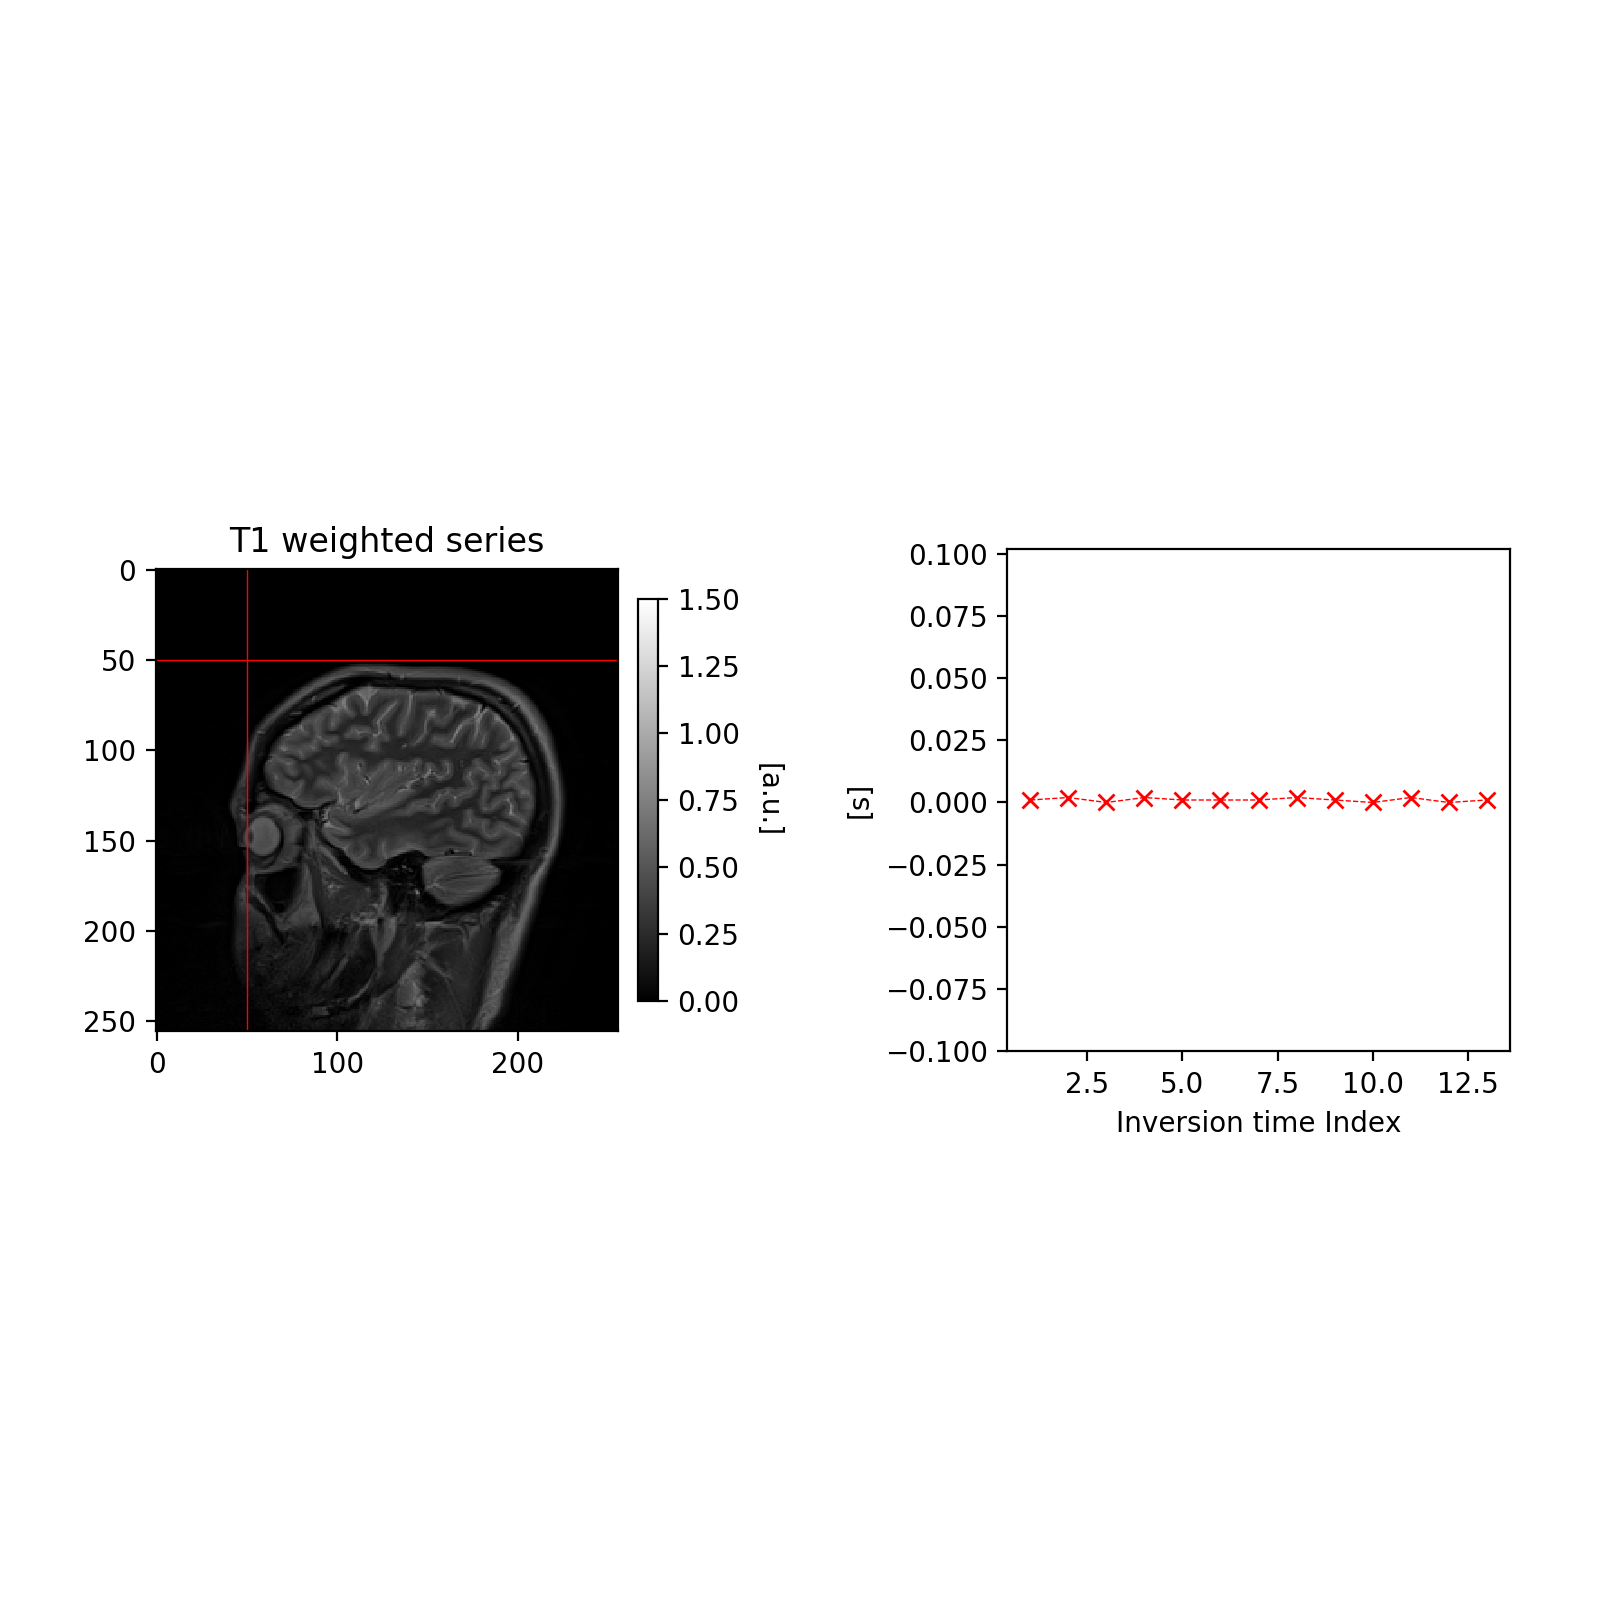

interactive(children=(IntSlider(value=6, description='inversion_time', max=12), Output()), _dom_classes=('widg…

In [3]:
imageBrowse(inVivoSeries["weighted_series"], 
            im_ax = 0,
            rang_min = 0.0,
            rang_max = 1.5,
            ylabel='[a.u.]'
           )

#### Perform T1 mapping on original data
Implement me...

In [6]:
qMaps, estimatedWeightedSeriesInVivo = t1Mapping(inVivoSeries)
inVivo_t1Map = qMaps[-1].detach().numpy()

----------------------------------------
T1 estimation started
Using CPU
Iteration: 0, Loss: 226477.49478787038
Iteration: 1, Loss: 222890.1694881218
Iteration: 2, Loss: 219469.215054285
Iteration: 3, Loss: 216209.30179780573
Iteration: 4, Loss: 213104.99660349343
Iteration: 5, Loss: 210151.1368089257
Iteration: 6, Loss: 207343.56309612584
Iteration: 7, Loss: 204677.356523265
Iteration: 8, Loss: 202139.8171973885
Iteration: 9, Loss: 199700.63556019196
Iteration: 10, Loss: 197315.23988855584
Iteration: 11, Loss: 194950.76701240498
Iteration: 12, Loss: 192592.77547833096
Iteration: 13, Loss: 190235.7493899891
Iteration: 14, Loss: 187873.70075968938
Iteration: 15, Loss: 185483.7262141862
Iteration: 16, Loss: 183113.99848626542
Iteration: 17, Loss: 180776.4432246753
Iteration: 18, Loss: 178478.8095443684
Iteration: 19, Loss: 176222.6023232735
Iteration: 20, Loss: 173999.58280482504
Iteration: 21, Loss: 171795.27793872636
Iteration: 22, Loss: 169601.66690375138
Iteration: 23, Loss: 167412.9

Iteration: 205, Loss: 3998.823112922999
Iteration: 206, Loss: 3852.2303672433486
Iteration: 207, Loss: 3709.2467889113946
Iteration: 208, Loss: 3569.798241375645
Iteration: 209, Loss: 3433.8734894388053
Iteration: 210, Loss: 3301.417976635563
Iteration: 211, Loss: 3172.3962826572965
Iteration: 212, Loss: 3046.7636002704835
Iteration: 213, Loss: 2924.4689560253737
Iteration: 214, Loss: 2805.499391617184
Iteration: 215, Loss: 2689.824458438032
Iteration: 216, Loss: 2577.4213232838574
Iteration: 217, Loss: 2468.273922357686
Iteration: 218, Loss: 2362.3623130574297
Iteration: 219, Loss: 2259.674503299957
Iteration: 220, Loss: 2160.147468413821
Iteration: 221, Loss: 2063.727400033737
Iteration: 222, Loss: 1970.4302760963385
Iteration: 223, Loss: 1880.170365230349
Iteration: 224, Loss: 1792.8820521136897
Iteration: 225, Loss: 1708.540755682236
Iteration: 226, Loss: 1627.125357497945
Iteration: 227, Loss: 1548.5899995136924
Iteration: 228, Loss: 1472.9049844649135
Iteration: 229, Loss: 1400.0

Iteration: 409, Loss: 296.8521974279562
Iteration: 410, Loss: 296.5843891474122
Iteration: 411, Loss: 296.311559676915
Iteration: 412, Loss: 296.07716315565244
Iteration: 413, Loss: 295.81114553440335
Iteration: 414, Loss: 295.5748009650199
Iteration: 415, Loss: 295.3541537999149
Iteration: 416, Loss: 295.0804784370007
Iteration: 417, Loss: 294.8732688794388
Iteration: 418, Loss: 294.6021172244018
Iteration: 419, Loss: 294.3891743251141
Iteration: 420, Loss: 294.1437137793331
Iteration: 421, Loss: 293.93341264125115
Iteration: 422, Loss: 293.7043505665034
Iteration: 423, Loss: 293.4702732580616
Iteration: 424, Loss: 293.27775102797267
Iteration: 425, Loss: 293.0482254434861
Iteration: 426, Loss: 292.8327515860654
Iteration: 427, Loss: 292.64514086930245
Iteration: 428, Loss: 292.4149659324937
Iteration: 429, Loss: 292.21444539344304
Iteration: 430, Loss: 292.02505519061106
Iteration: 431, Loss: 291.87131670590355
Iteration: 432, Loss: 291.6434232864958
Iteration: 433, Loss: 291.4566540

#### Check residuals
Implement me...

<IPython.core.display.Javascript object>


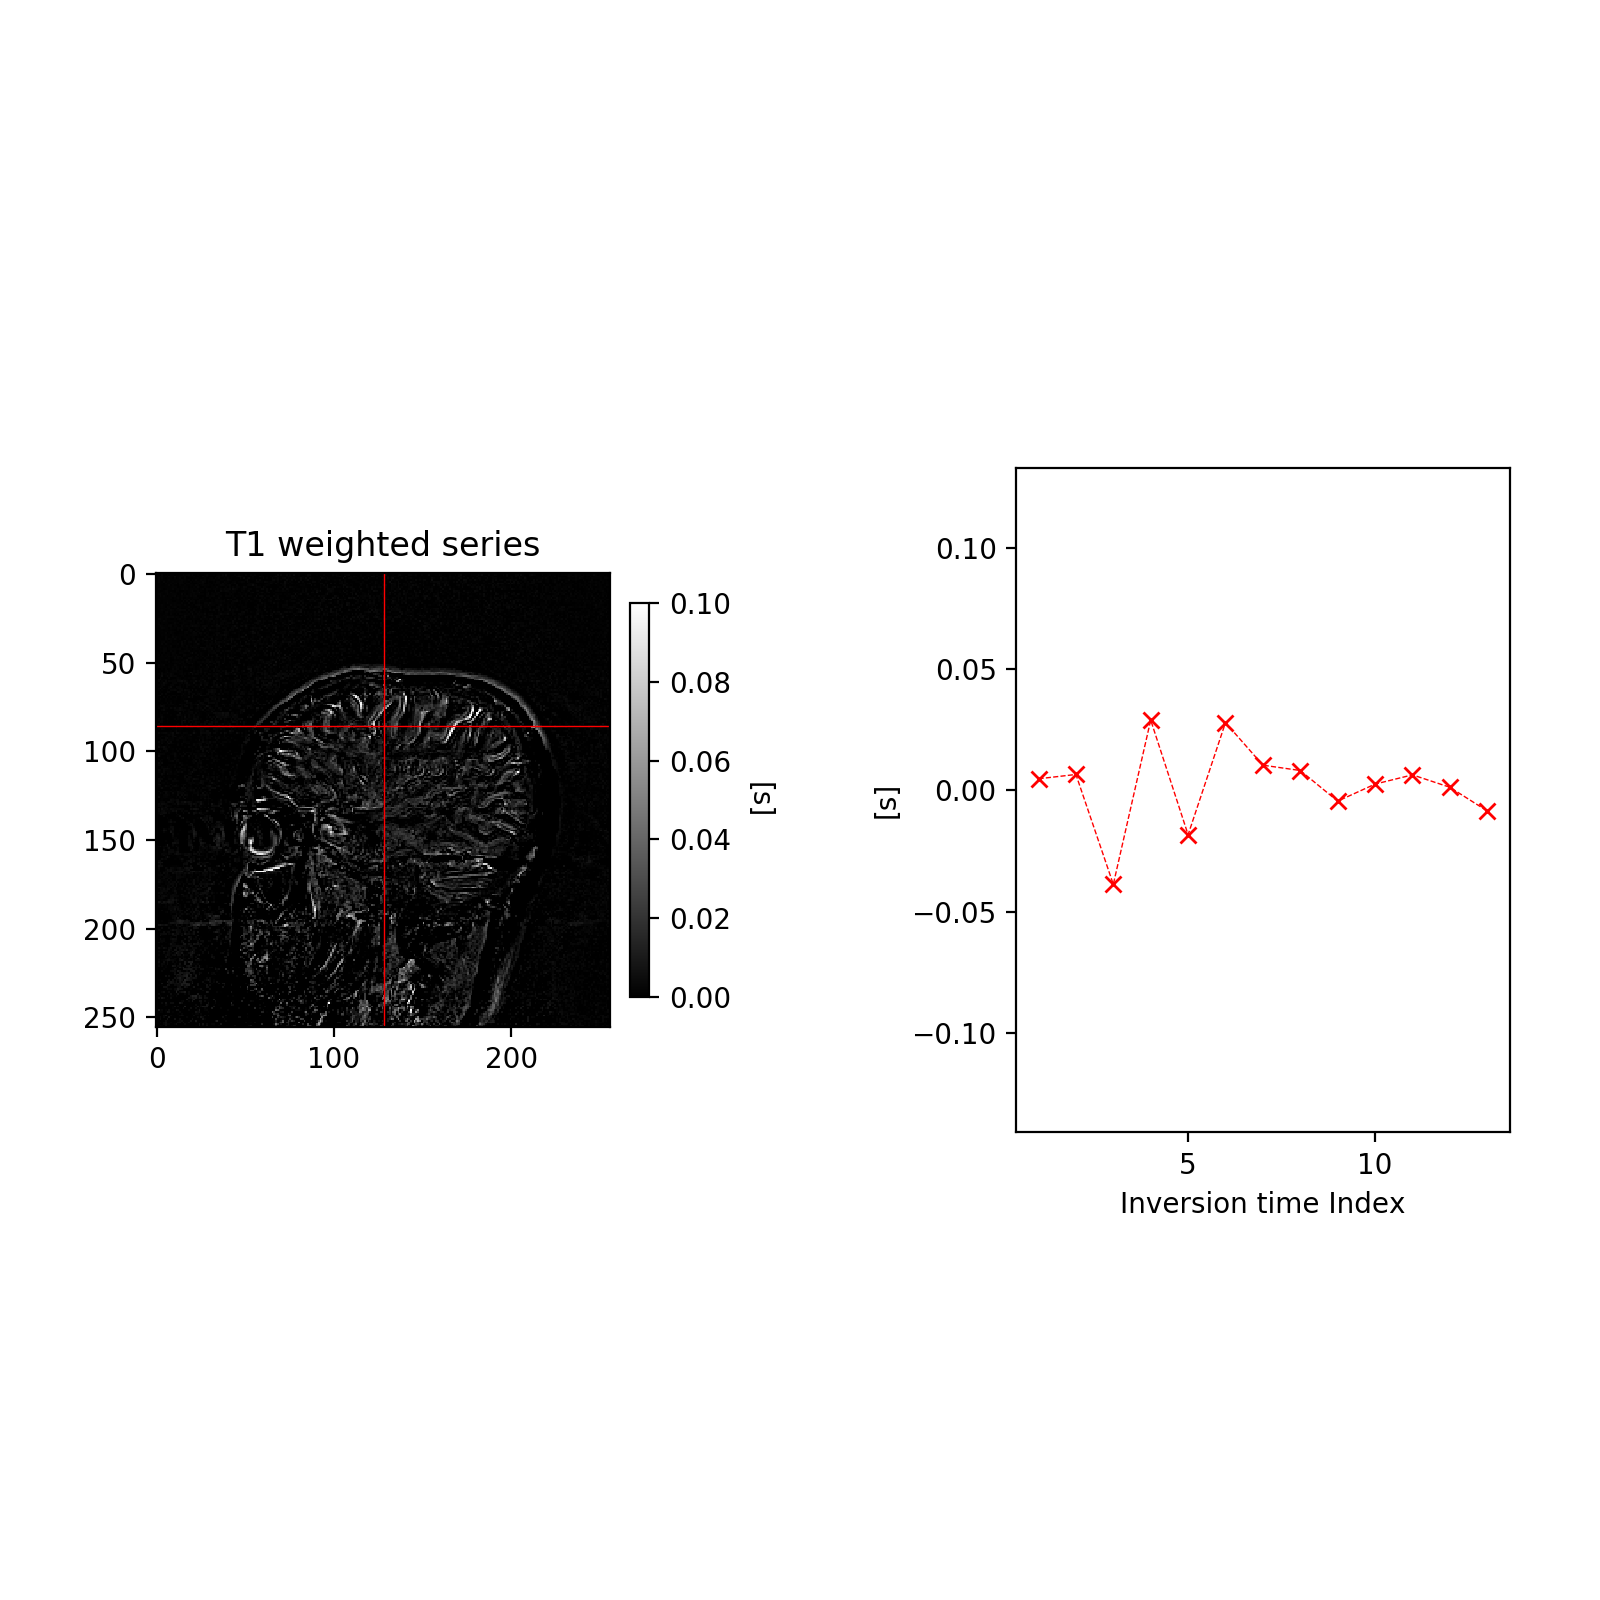

interactive(children=(IntSlider(value=6, description='inversion_time', max=12), Output()), _dom_classes=('widg…

In [10]:
residualInVivo = estimatedWeightedSeriesInVivo - inVivoSeries["weighted_series"]
imageBrowse(residualInVivo, im_ax = 0, rang_min = 0.0, rang_max = 0.1)

#### Perform registration
Implement me...

In [7]:
filePath = "./support_data/inVivo3D.nii"
parameterFilePath = "./ParametersFile/par_groupwise/par_real_data/par_groupwise_DTI-BRAIN.txt"

sitk_fixed, sitk_moving = dataManage.prepareDataForElastix(filePath)
processedData, transformParameterMap = elastixRegister(sitk_fixed, sitk_moving, parameterFilePath)

registeredSeries = {}
registeredSeries['weighted_series'] = processedData
registeredSeries['echo_times'] = inVivoSeries['echo_times']

Applying registration
Registration finished


#### Visualise the registered data
Implement me...

<IPython.core.display.Javascript object>


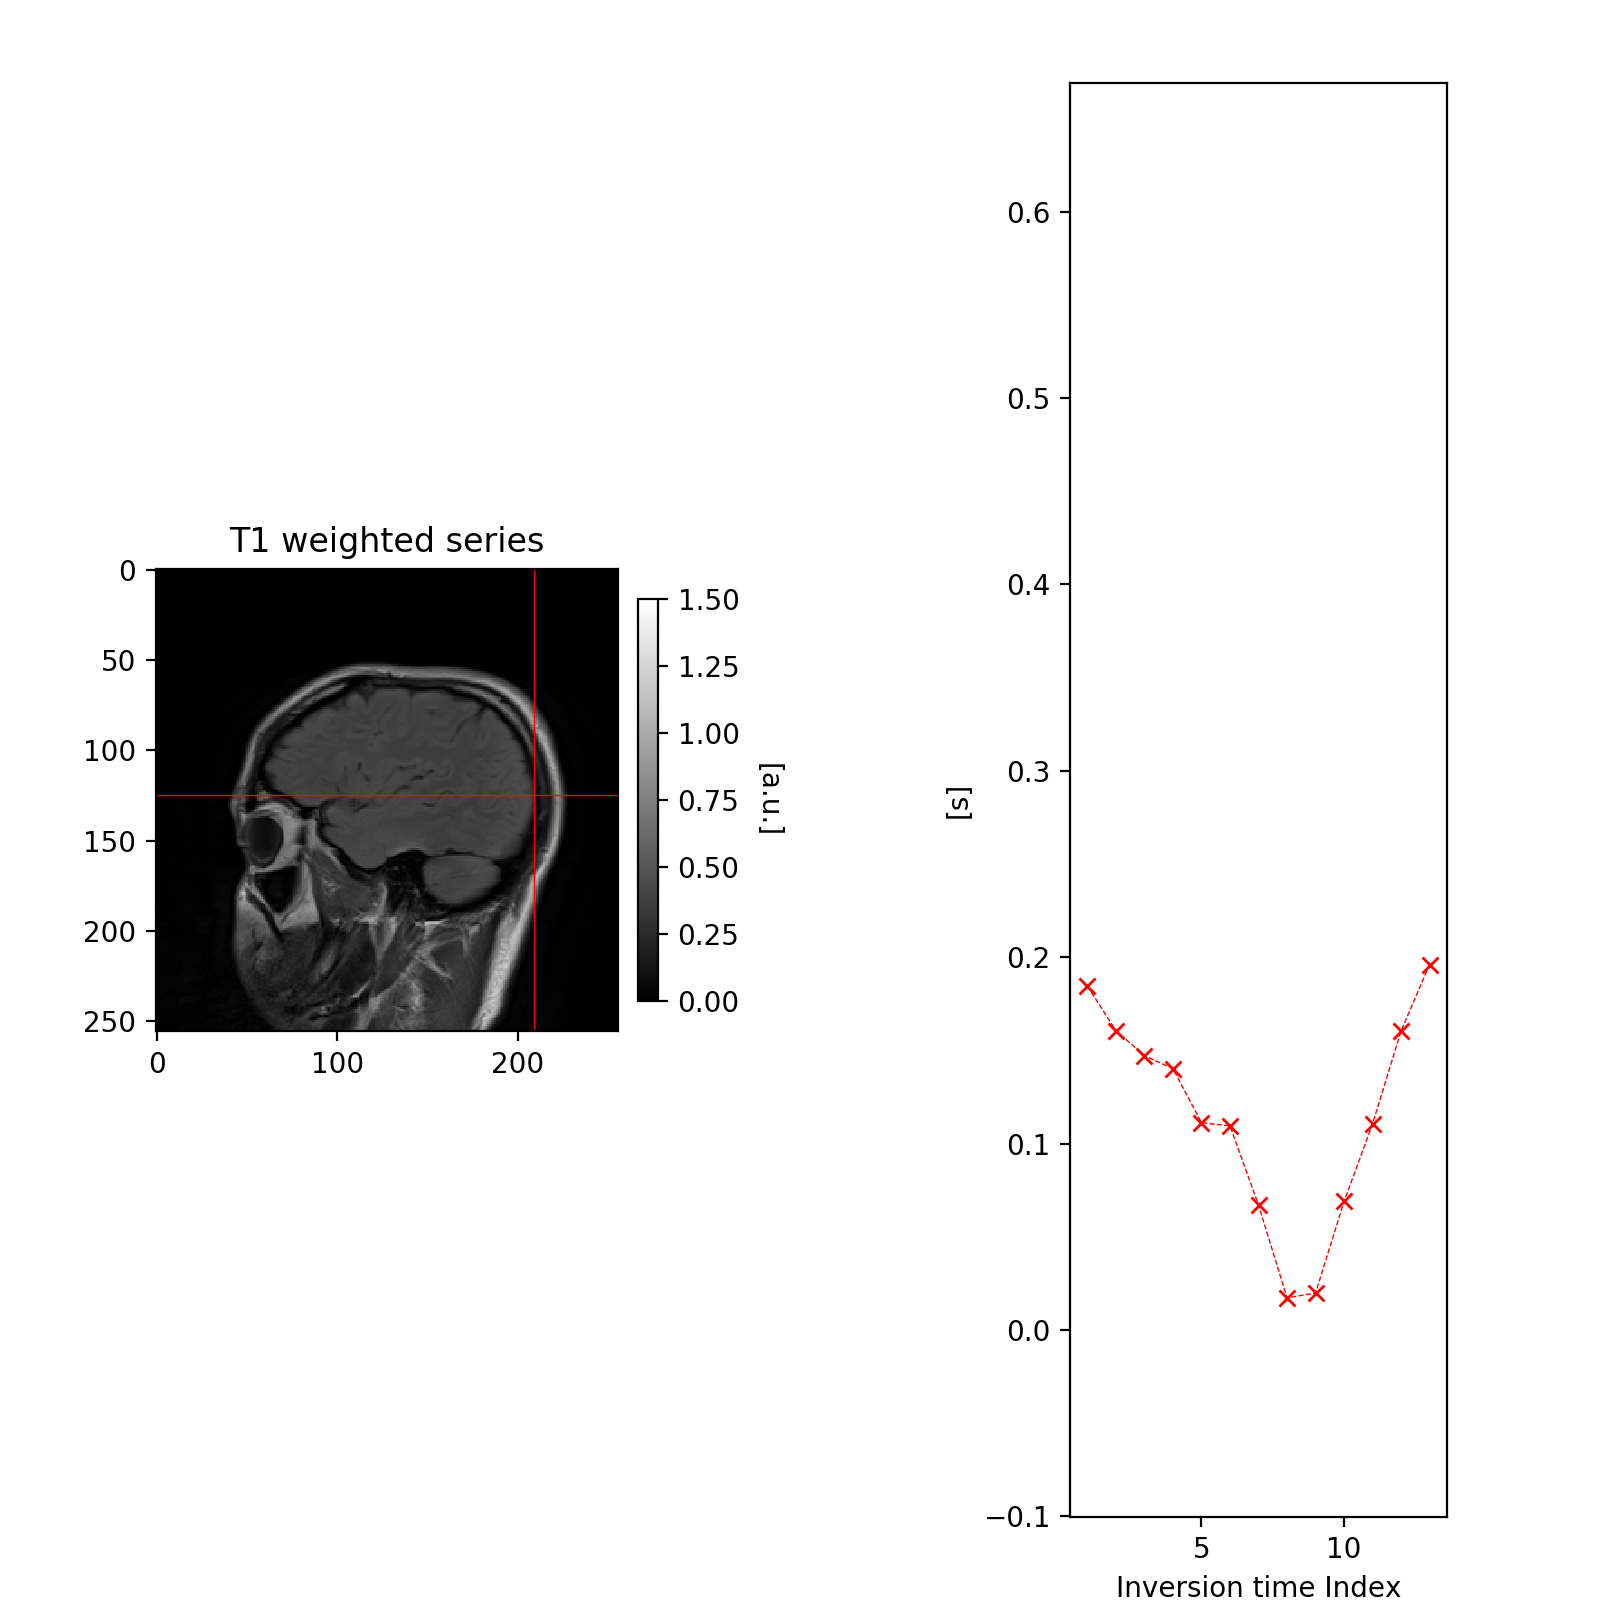

interactive(children=(IntSlider(value=6, description='inversion_time', max=12), Output()), _dom_classes=('widg…

In [9]:
imageBrowse(registeredSeries['weighted_series'][:,:,:,10], 
            im_ax = 0, 
            rang_min = 0.0,
            rang_max = 1.5,
            ylabel='[a.u.]')

#### Performing T1 mapping on registered data
Implement me...

In [ ]:
qMaps, estimatedWeightedSeriesInVivoRegistered = t1Mapping(registeredSeries)
inVivo_t1MapRegistered = qMaps[-1].detach().numpy()

#### Check residuals
Implement me...

In [ ]:
residualInVivoRegistered = estimatedWeightedSeriesInVivoRegistered - inVivoSeries["weighted_series"]
imageBrowse(residualInVivoRegistered, im_ax = 0, rang_min = 0.0, rang_max = 0.1)

#### Compare original and registered maps
Implement me...

In [ ]:
image_utilities.compare_predictions(inVivo_t1Map, inVivo_t1MapRegistered)